<a href="https://colab.research.google.com/github/lizanakiranda/Ghana-Challenge/blob/main/Final_Ghana_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE

#imported ffrom the classification notebook
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GhanaChallenge/ghanachallenge/test.csv")

In [ ]:
trainweather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GhanaChallenge/ghanachallenge/train.csv")

In [ ]:
trainweather.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,Target,forecast_length
0,ID_KwcTp_12,11,0.3,0.0,Tumfa,atiwa_west,2025-05-30 11:09:33,NaN,NaN,NaN,MEDIUMRAIN,12
1,ID_K9vWT_12,17,0.3,0.0,Kwabeng,atiwa_west,2025-05-30 11:09:35,NaN,NaN,NaN,HEAVYRAIN,12
2,ID_AIQg3_12,19,0.3,0.0,Akropong,atiwa_west,2025-05-30 11:09:47,NaN,NaN,NaN,MEDIUMRAIN,12
3,ID_px4yf_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:33,NaN,NaN,NaN,HEAVYRAIN,12
4,ID_QYYmK_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:55,NaN,NaN,NaN,HEAVYRAIN,12


In [ ]:
trainweather.shape

(10928, 12)

In [ ]:
trainweather.dtypes

,0
ID,object
user_id,int64
confidence,float64
predicted_intensity,float64
community,object
district,object
prediction_time,object
indicator,object
indicator_description,object
time_observed,object


In [ ]:
trainweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10928 entries, 0 to 10927
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     10928 non-null  object 
 1   user_id                10928 non-null  int64  
 2   confidence             10928 non-null  float64
 3   predicted_intensity    10928 non-null  float64
 4   community              10928 non-null  object 
 5   district               10928 non-null  object 
 6   prediction_time        10928 non-null  object 
 7   indicator              503 non-null    object 
 8   indicator_description  346 non-null    object 
 9   time_observed          72 non-null     object 
 10  Target                 10928 non-null  object 
 11  forecast_length        10928 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 1.0+ MB


In [ ]:
trainweather.isnull().sum()

,0
ID,0
user_id,0
confidence,0
predicted_intensity,0
community,0
district,0
prediction_time,0
indicator,10425
indicator_description,10582
time_observed,10856


In [ ]:
trainweather.describe()

,user_id,confidence,predicted_intensity,forecast_length
count,10928.000000,10928.000000,10928.000000,10928.000000
mean,40.534407,0.540474,0.026830,19.135432
std,22.970174,0.272068,0.132468,5.891856
min,7.000000,0.300000,0.000000,12.000000
25%,20.000000,0.300000,0.000000,12.000000
50%,43.000000,0.600000,0.000000,24.000000
75%,62.000000,0.600000,0.000000,24.000000
max,90.000000,1.000000,1.000000,24.000000


In [ ]:
print(trainweather.duplicated().sum())

0


EDA

In [ ]:
#the indicator column null values have to be filled
# Step 1: Define mapping between target and indicator
indicator_map = {
    'NORAIN': ['dew', 'fog', 'thunder', 'star', 'moon', 'heat','sun', 'wind','clouds'],
    'SMALLRAIN': ['wind', 'star', 'moon', 'sun','clouds'],
    'MEDIUMRAIN': ['heat', 'lightning', 'sun','clouds'],
    'HEAVYRAIN': ['heat', 'sun','clouds']
}

# Step 2: Fill null indicators based on the target column
def fill_indicator(row):
    if pd.isna(row['indicator']):
        options = indicator_map[row['Target']]
        return np.random.choice(options)
    return row['indicator']

trainweather['indicator'] = trainweather.apply(fill_indicator, axis=1)

# Step 3: Confirm all filled
print(trainweather['indicator'].isna().sum())  # should print 0

0


In [ ]:
trainweather.groupby(['Target', 'indicator']).size()




Target      indicator
HEAVYRAIN   clouds        100
            heat          107
            sun           108
MEDIUMRAIN  clouds        213
            heat          177
            lightning     197
            sun           174
NORAIN      clouds       1249
            dew          1017
            fog          1092
            heat         1068
            lightning       1
            moon         1035
            star         1016
            sun          1094
            thunder      1018
            wind         1022
SMALLRAIN   clouds         61
            moon           42
            star           44
            sun            47
            wind           46
dtype: int64

In [ ]:
# make sure it's in datetime format
trainweather["prediction_time"] = pd.to_datetime(trainweather["prediction_time"])

# extract date only
trainweather["prediction_date"] = trainweather["prediction_time"].dt.date
trainweather["prediction_year"] = trainweather["prediction_time"].dt.year
trainweather["prediction_month"] = trainweather["prediction_time"].dt.month
trainweather["prediction_day"] = trainweather["prediction_time"].dt.day

# extract time only
trainweather["prediction_hour"] = trainweather["prediction_time"].dt.hour   # just the hour
#trainweather["prediction_minute"] = trainweather["prediction_time"].dt.minute
#trainweather["prediction_second"] = trainweather["prediction_time"].dt.second

# OR if you want full time object (HH:MM:SS)
#trainweather["prediction_time_only"] = trainweather["prediction_time"].dt.time


In [ ]:
trainweather.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,Target,forecast_length,prediction_date,prediction_year,prediction_month,prediction_day,prediction_hour
0,ID_KwcTp_12,11,0.3,0.0,Tumfa,atiwa_west,2025-05-30 11:09:33,heat,NaN,NaN,MEDIUMRAIN,12,2025-05-30,2025,5,30,11
1,ID_K9vWT_12,17,0.3,0.0,Kwabeng,atiwa_west,2025-05-30 11:09:35,sun,NaN,NaN,HEAVYRAIN,12,2025-05-30,2025,5,30,11
2,ID_AIQg3_12,19,0.3,0.0,Akropong,atiwa_west,2025-05-30 11:09:47,sun,NaN,NaN,MEDIUMRAIN,12,2025-05-30,2025,5,30,11
3,ID_px4yf_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:33,clouds,NaN,NaN,HEAVYRAIN,12,2025-05-30,2025,5,30,11
4,ID_QYYmK_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:55,clouds,NaN,NaN,HEAVYRAIN,12,2025-05-30,2025,5,30,11


In [ ]:
cat_cols = trainweather.select_dtypes('object').columns
num_cols = trainweather.select_dtypes(["int","float"]).columns

working with categorical columns

In [ ]:
# get the number of unique values in each column

for col in cat_cols:
    print(f"{col} have {trainweather[col].nunique()} labels")

ID have 10928 labels
community have 38 labels
district have 3 labels
indicator have 10 labels
indicator_description have 28 labels
time_observed have 8 labels
Target have 4 labels
prediction_date have 50 labels


In [ ]:
trainweather.drop(["indicator_description", "time_observed", "prediction_time", "prediction_date","prediction_year","community","district"], axis=1, inplace=True)
cat_cols = cat_cols.drop(["indicator_description","time_observed","prediction_time","prediction_date","community","district"])

KeyError: "['prediction_time'] not found in axis"

In [ ]:
trainweather.head()

,ID,user_id,confidence,predicted_intensity,indicator,Target,forecast_length,prediction_month,prediction_day,prediction_hour
0,ID_KwcTp_12,11,0.3,0.0,heat,MEDIUMRAIN,12,5,30,11
1,ID_K9vWT_12,17,0.3,0.0,sun,HEAVYRAIN,12,5,30,11
2,ID_AIQg3_12,19,0.3,0.0,sun,MEDIUMRAIN,12,5,30,11
3,ID_px4yf_12,23,0.3,0.0,clouds,HEAVYRAIN,12,5,30,11
4,ID_QYYmK_12,23,0.3,0.0,clouds,HEAVYRAIN,12,5,30,11


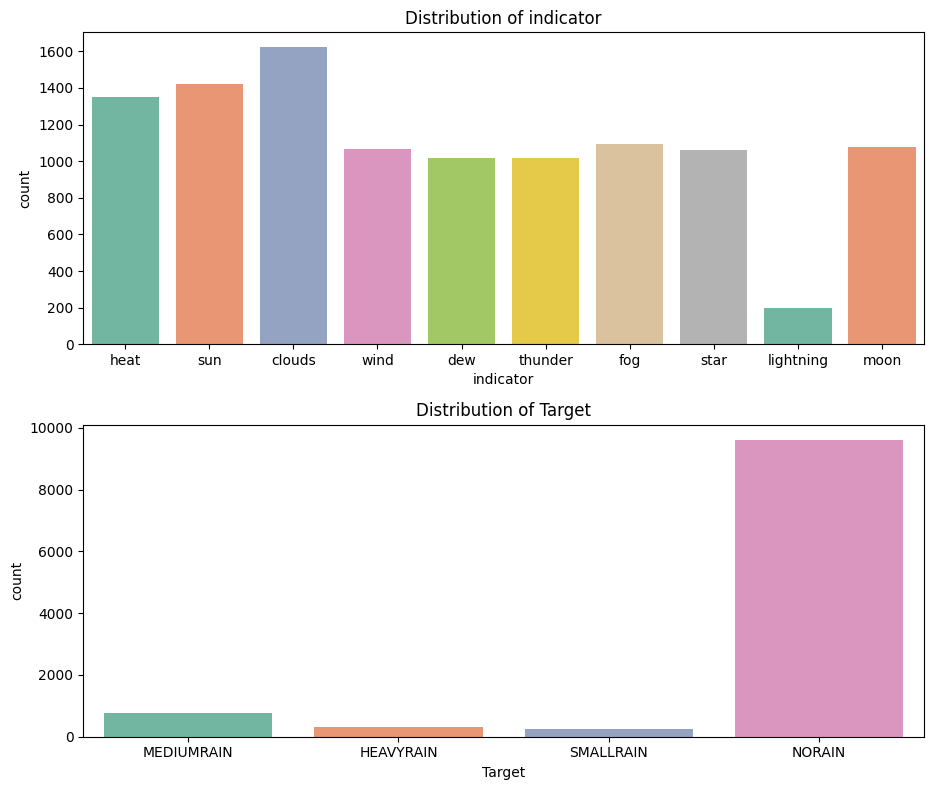

In [ ]:
cols = ["indicator" ,"Target"]
plt.figure(figsize=(18,8))

for i,col in enumerate(cols):  # 0 ,1
      # Countplot
    plt.subplot(2, 2,2*i+1)   # 1 ,3
    sns.countplot(x=col, data=trainweather, palette="Set2")
    plt.title(f"Distribution of {col}")



plt.tight_layout()
plt.show()

In [ ]:
# get the relationship between number of rain and indicators
pd.crosstab(trainweather["indicator"],trainweather["Target"] , normalize=True)*100

Target,HEAVYRAIN,MEDIUMRAIN,NORAIN,SMALLRAIN
indicator,,,,
clouds,0.915081,1.949122,11.429356,0.558199
dew,0.000000,0.000000,9.306369,0.000000
fog,0.000000,0.000000,9.992679,0.000000
heat,0.979136,1.619693,9.773060,0.000000
lightning,0.000000,1.802709,0.009151,0.000000
moon,0.000000,0.000000,9.471083,0.384334
star,0.000000,0.000000,9.297218,0.402635
sun,0.988287,1.592240,10.010981,0.430088
thunder,0.000000,0.000000,9.315520,0.000000


Handling numerical columns

In [ ]:
print(f"The number of numerical columns {len(num_cols)}")

The number of numerical columns 8


In [ ]:
num_cols

Index(['user_id', 'confidence', 'predicted_intensity', 'forecast_length',
       'prediction_year', 'prediction_month', 'prediction_day',
       'prediction_hour'],
      dtype='object')

Encoding

In [ ]:
# Create a copy
train_encoded = trainweather.copy()

# Initialize encoder

le_target = LabelEncoder()
le_indicator = LabelEncoder()

trainweather['Target'] = le_target.fit_transform(trainweather['Target'].astype(str))
trainweather['indicator'] = le_indicator.fit_transform(trainweather['indicator'].astype(str))


Correlation matrix

Feature correlations with Target:
Target                 1.000000
confidence             0.239886
user_id                0.217224
prediction_day         0.119170
indicator              0.104274
predicted_intensity    0.007168
prediction_month      -0.041677
prediction_hour       -0.051811
forecast_length       -0.075225
dtype: float64


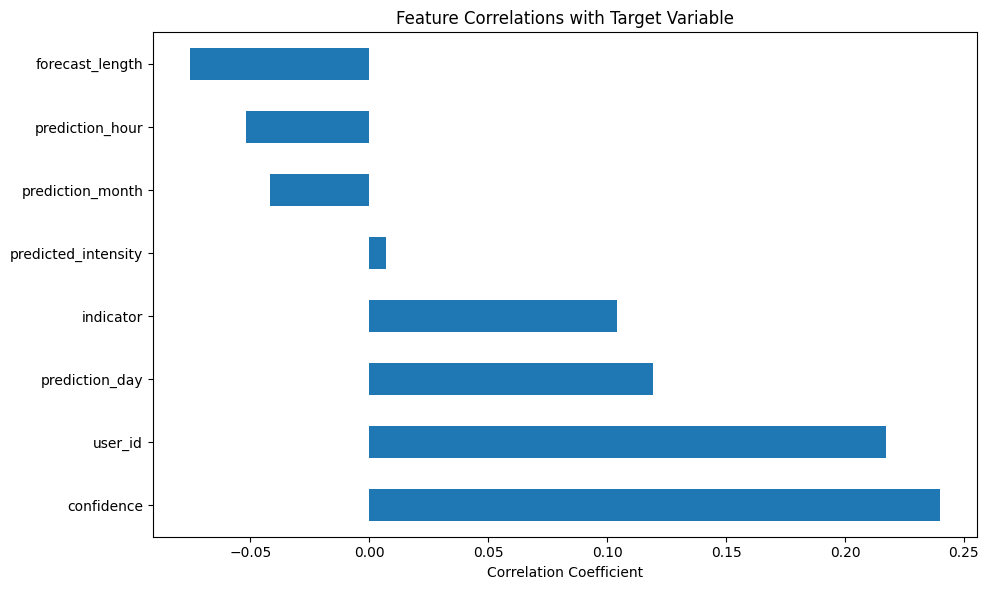

In [ ]:
#correlations with target
# Assuming your encoded target column is still called 'Target'
target_correlations = train_encoded.drop('ID', axis=1).corrwith(train_encoded['Target']).sort_values(ascending=False)

print("Feature correlations with Target:")
print(target_correlations)

# Plot the top correlations with target
plt.figure(figsize=(10, 6))
target_correlations.drop('Target').plot(kind='barh')  # Drop target itself
plt.title('Feature Correlations with Target Variable')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

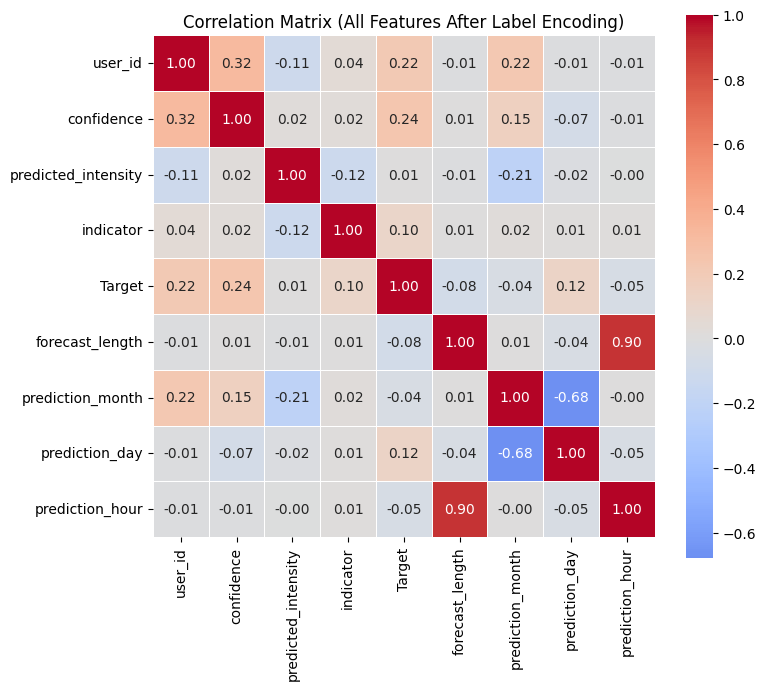

In [ ]:
#Drop ID column explicitly
correlation_matrix = train_encoded.drop('ID', axis=1).corr()

# Method 2: Select all columns except ID (more explicit)
correlation_matrix = train_encoded[[col for col in train_encoded.columns if col != 'ID']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Matrix (All Features After Label Encoding)')
plt.tight_layout()
plt.show()


Feature selection

Involves selecting features that will be used in the model

In [ ]:
X = train_encoded.drop(columns=["ID", "Target"], axis=1)
y = train_encoded["Target"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print('Train Shape:', X_train.shape)
print('Test Shape:', X_test.shape)

print('\nClass Distribution in the train set:')
print(y_train.value_counts())
print('\nClass Distribution in the test set:')
print(y_test.value_counts())

Train Shape: (8742, 8)
Test Shape: (2186, 8)

Class Distribution in the train set:
Target
2    7689
1     609
0     252
3     192
Name: count, dtype: int64

Class Distribution in the test set:
Target
2    1923
1     152
0      63
3      48
Name: count, dtype: int64


In [ ]:
# Check class distribution
print("Class distribution:")
print(y.value_counts())

# If classes are very imbalanced, use SMOTE

Class distribution:
Target
2    9612
1     761
0     315
3     240
Name: count, dtype: int64


In [ ]:
#Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {pd.Series(y_train_resampled).value_counts()}")

Before SMOTE: Target
2    7689
1     609
0     252
3     192
Name: count, dtype: int64
After SMOTE: Target
2    7689
0    7689
1    7689
3    7689
Name: count, dtype: int64


In [ ]:
# Apply scaling on training data, then transform test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

BUILDING MODELS

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train_scaled, y_train_resampled)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0     0.9993    0.9952    0.9973      7689
           1     0.9952    0.9993    0.9973      7689
           2     1.0000    1.0000    1.0000      7689
           3     1.0000    1.0000    1.0000      7689

    accuracy                         0.9986     30756
   macro avg     0.9986    0.9986    0.9986     30756
weighted avg     0.9986    0.9986    0.9986     30756



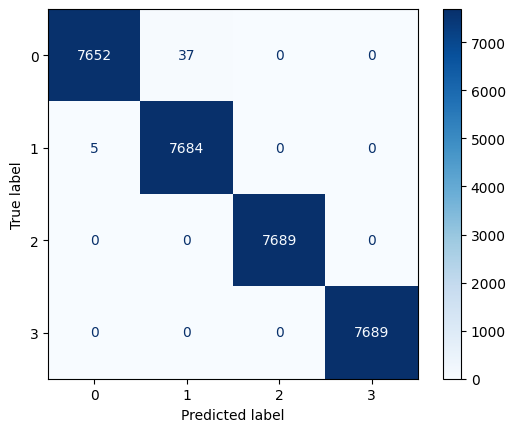

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# check on train

train_pred = dtc.predict(X_train_scaled)

print(classification_report(y_train_resampled , train_pred,digits=4))

conf= confusion_matrix(y_train_resampled,train_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

              precision    recall  f1-score   support

           0     0.8971    0.9683    0.9313        63
           1     0.9730    0.9474    0.9600       152
           2     0.9953    0.9932    0.9943      1923
           3     0.8235    0.8750    0.8485        48

    accuracy                         0.9867      2186
   macro avg     0.9222    0.9460    0.9335      2186
weighted avg     0.9872    0.9867    0.9869      2186



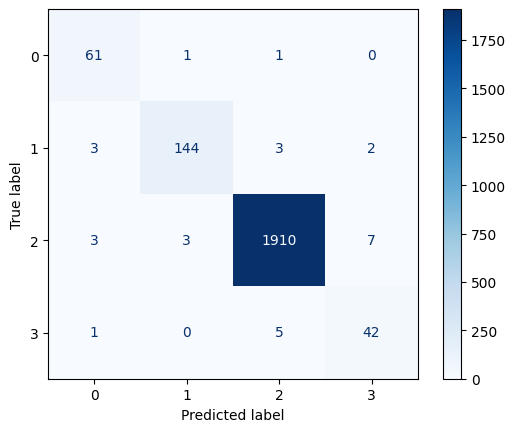

In [ ]:
# check on test

test_pred = dtc.predict(X_test_scaled)

print(classification_report(y_test , test_pred,digits=4))

conf= confusion_matrix(y_test,test_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train_resampled)

In [ ]:
y_pred = logreg.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# check on train

train_pred = logreg.predict(X_train_scaled)

print(classification_report(y_train_resampled , train_pred,digits=4))

conf= confusion_matrix(y_train_resampled,train_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

In [ ]:
# check on test

test_pred = logreg.predict(X_test_scaled)

print(classification_report(y_test , test_pred,digits=4))

conf= confusion_matrix(y_test,test_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rf.fit(X_train_scaled, y_train_resampled)

In [ ]:
# check on train

train_pred = rf.predict(X_train_scaled)

print(classification_report(y_train_resampled , train_pred,digits=4))

conf= confusion_matrix(y_train_resampled,train_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

In [ ]:
test_pred = rf.predict(X_test_scaled)

print(classification_report(y_test , test_pred,digits=4))

conf= confusion_matrix(y_test,test_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

In [ ]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train_resampled)

In [ ]:
# check on train

train_pred = logreg.predict(X_train_scaled)

print(classification_report(y_train_resampled , train_pred,digits=4))

conf= confusion_matrix(y_train_resampled,train_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

In [ ]:
kn = KNeighborsClassifier()
kn.fit(X_train_scaled, y_train_resampled)

In [ ]:
# check on train

train_pred = logreg.predict(X_train_scaled)

print(classification_report(y_train_resampled , train_pred,digits=4))

conf= confusion_matrix(y_train_resampled,train_pred)
dis = ConfusionMatrixDisplay(conf)
dis = ConfusionMatrixDisplay(confusion_matrix=conf)
dis.plot(cmap="Blues")
plt.show()

SUBMISSION

In [ ]:
#weather is our test_df
weather.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,forecast_length
0,ID_SbTdy_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:28,NaN,NaN,NaN,24
1,ID_SBKYz_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:29,NaN,NaN,NaN,24
2,ID_fAimg_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:30,NaN,NaN,NaN,24
3,ID_2wBqC_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:31,NaN,NaN,NaN,24
4,ID_NItox_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:32,NaN,NaN,NaN,24


In [ ]:
weatherid = weather["ID"]

In [ ]:
# make sure it's in datetime format
weather["prediction_time"] = pd.to_datetime(weather["prediction_time"])

# extract date only
weather["prediction_date"] = weather["prediction_time"].dt.date
weather["prediction_year"] = weather["prediction_time"].dt.year
weather["prediction_month"] = weather["prediction_time"].dt.month
weather["prediction_day"] = weather["prediction_time"].dt.day

# extract time only
weather["prediction_hour"] = weather["prediction_time"].dt.hour   # just the hour
#trainweather["prediction_minute"] = trainweather["prediction_time"].dt.minute
#trainweather["prediction_second"] = trainweather["prediction_time"].dt.second

# OR if you want full time object (HH:MM:SS)
#trainweather["prediction_time_only"] = trainweather["prediction_time"].dt.time

In [ ]:
weather.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,forecast_length,prediction_date,prediction_year,prediction_month,prediction_day,prediction_hour
0,ID_SbTdy_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:28,NaN,NaN,NaN,24,2025-07-20,2025,7,20,19
1,ID_SBKYz_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:29,NaN,NaN,NaN,24,2025-07-20,2025,7,20,19
2,ID_fAimg_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:30,NaN,NaN,NaN,24,2025-07-20,2025,7,20,19
3,ID_2wBqC_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:31,NaN,NaN,NaN,24,2025-07-20,2025,7,20,19
4,ID_NItox_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:32,NaN,NaN,NaN,24,2025-07-20,2025,7,20,19


In [ ]:
weather.drop(["indicator_description","time_observed","prediction_date","prediction_year","prediction_time","community","district"], axis=1, inplace=True)

In [ ]:
weather.head()

,ID,user_id,confidence,predicted_intensity,indicator,forecast_length,prediction_month,prediction_day,prediction_hour
0,ID_SbTdy_24,77,0.3,0.0,NaN,24,7,20,19
1,ID_SBKYz_24,77,0.3,0.0,NaN,24,7,20,19
2,ID_fAimg_24,77,0.3,0.0,NaN,24,7,20,19
3,ID_2wBqC_24,77,0.3,0.0,NaN,24,7,20,19
4,ID_NItox_24,77,0.3,0.0,NaN,24,7,20,19


In [ ]:
#the indicator column null values have to be filled


# Get existing indicator values from training data
indicators_list = weather['indicator'].dropna().unique()

# Fill missing indicators in test data randomly
weather['indicator'] = weather['indicator'].apply(
    lambda x: np.random.choice(indicators_list) if pd.isna(x) else x
)

In [ ]:
weather.head()

,ID,user_id,confidence,predicted_intensity,indicator,forecast_length,prediction_month,prediction_day,prediction_hour
0,ID_SbTdy_24,77,0.3,0.0,star,24,7,20,19
1,ID_SBKYz_24,77,0.3,0.0,thunder,24,7,20,19
2,ID_fAimg_24,77,0.3,0.0,fog,24,7,20,19
3,ID_2wBqC_24,77,0.3,0.0,wind,24,7,20,19
4,ID_NItox_24,77,0.3,0.0,fog,24,7,20,19


In [ ]:
category_cols = weather.select_dtypes('object').columns

In [ ]:
category_cols

Index(['ID', 'indicator'], dtype='object')

In [ ]:
# Create a mapping dictionary from the fitted encoder
indicator_mapping = dict(zip(le_indicator.classes_, le_indicator.transform(le_indicator.classes_)))

# Safely map test indicators, assigning -1 to unseen values
weather['indicator'] = weather['indicator'].map(indicator_mapping).fillna(-1).astype(int)


In [ ]:
weather.head()

,ID,user_id,confidence,predicted_intensity,indicator,forecast_length,prediction_month,prediction_day,prediction_hour
0,ID_SbTdy_24,77,0.3,0.0,-1,24,7,20,19
1,ID_SBKYz_24,77,0.3,0.0,-1,24,7,20,19
2,ID_fAimg_24,77,0.3,0.0,-1,24,7,20,19
3,ID_2wBqC_24,77,0.3,0.0,-1,24,7,20,19
4,ID_NItox_24,77,0.3,0.0,-1,24,7,20,19


In [ ]:
# Select only the column for prediction
weather_test = weather[["indicator","user_id","confidence","predicted_intensity","forecast_length","prediction_month","prediction_day","prediction_hour"]]

In [ ]:
scaler = StandardScaler()
weather_test = pd.DataFrame(scaler.fit_transform(weather_test))

In [ ]:
predictions = dtc.predict(weather_test)

decoded_predictions = le_target.inverse_transform(predictions)

output = pd.DataFrame({'ID': weatherid, 'Target': decoded_predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
